In [12]:
#Path and file names
# Add the parent directory to the path for the windtunnel package import
path_dir = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare"
#Path to your input data
#path = f"{path_dir}/ExampleData/InputData/Concentration/"
#path = f"{path_dir}/ExampleData/InputData/Beispiel Umrechnung zur Kontrolle/"
path = f"/home/sabrina/Schreibtisch/Arbeit_2025/Nora_test/"
# Name of your measurement files prefix
#namelist = ['BFS_BD3_MP01_000']
namelist = ['UBA_thesis'] #['UBA_GA_02_04_01_000_1_001'] #['UBA_thesis'] #
#Path to your output folder for average files and plots
output_path = f"{path_dir}/ExampleData/Results/"
SaveOutputFiles=True #Save calculated quantities whole ts 
SaveOutputFilesStats=True #Avg and stats files
osType = "Linux"
#For PointData for the functions to work the columns of the file should be: time, wtref, slow_FID, fast_FID, open_rate
#(See manual for the description of the variables)
#Name of csv file which contains ambient conditions data. Multiple diff. ambient conditions for diff datasets can be read-in at ones
#If no file given or configuration wrong, the program ressorts to try reading-in given values manually below. 
#csv_file='ambient_conditions.csv'
#csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions.csv"
#csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions_.UBA_GA.csv"
csv_file= f"{path}ambient_conditions_point1.csv"
parameters_PerFolder = False

#Variables and Parameters set for all ts, if no ambient_conditions.csv file overgiven
#If at the end calculate entdimensionalised or full scale transform quantities
#Default: nd:entdimensionalise, ms:model scale, fs:full scale.    
full_scale='ms'

#Postprocessing before analysis
applyPostprocessing=True
averageInterval=60 #s  #Interval to downaverage raw time series to before analysis
#Overgive uncertainty
uncertainty_value=None #Uncertainty of concentration, has to be calculated/estimated from the experimentator
#If None overgive no error visualized as errorbars 0.5
uncertainty_representation="percentage" #"absoluteValue"

In [13]:
#Example file/Default environment values if no csv_file found:
#Source location  [mm]
x_source=0
y_source=0
z_source=0
#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #0.600#Stickstoffdurchflussregler #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=1.0     #0.3     #0.3 oder 3
calibration_factor=0 #1      #
#Gas characteristics
gas_name='C12'           #Just placeholder name variable for orientation, not used for anything
gas_factor=0.5   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=29.0 #28.97 #Air [g/mol]
#Measurement location [mm]
x_measure=1020 #855.16
y_measure= 0    #176.29
z_measure= 5     #162
#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]
#Model to Reality scaling
scale=400                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/400              #1/250           #Lref
ref_height=100/400            #None            #Href

full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)
#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'

In [14]:
#Imports
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#sys.path.append(os.path.abspath(path_dir))
import windtunnel as wt

###### Initialise concentration ts dictionary of length namelist, as well as for full scale and entdimensionalised
conc_ts = {}
conc_ts.fromkeys(namelist)
conc_ts_fs = conc_ts
conc_ts_nd = conc_ts

dict_conc_ts = conc_ts
dict_conc_nd = conc_ts
dict_conc_fs = conc_ts

data_dict = {}
data_dict.fromkeys(namelist)

#Edited Nora: Check if ambient conditions file is even there, before trying out reading-in
print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)
#Read in ambient conditions for each folder or concentration ts from given csv file or for same conditions from manually
parameters_PerFolder = parameters_PerFolder #False  #True=for each folder/namelist entry new column, False: for each ts one column entry

for name in namelist:
    files = wt.get_files(path, name)
    print(f"files: {files}")

    #Initilise Dictionary for each given name containing dimensions of nr of files ts#0-
    conc_ts[name] = {}
    conc_ts[name].fromkeys(files)
    
    if parameters_PerFolder==True:
        #Read ambient conditions from csv file only for each folder
        ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=name, input_file=csv_file)
        #print(ambient_conditions)
        #Else read/use given default from cell above
        if ambient_conditions is None:
            []
        #Read ambient conditions from csv file
        else:
            x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
            ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure, config_name = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, name)
            
        
    for file in files:
        if parameters_PerFolder == False:
            #Read in ambient condition column for each ts
            ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=file, input_file=csv_file)
            #Else read/use given default from cell above
            if ambient_conditions is None:
                []
            #Read ambient conditions from csv file
            else:
                x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
                ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure,  config_name= wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, file)

        conc_ts[name][file] = wt.PointConcentration.from_file(path + file)
    
        conc_ts[name][file].ambient_conditions(x_source=x_source, y_source=y_source, z_source=z_source,
                                               x_measure=x_measure, y_measure=y_measure, z_measure=z_measure,
                                               pressure=pressure,
                                               temperature=temperature,
                                               calibration_curve=calibration_curve,
                                               mass_flow_controller=mass_flow_controller,
                                               calibration_factor=calibration_factor,
                                               config_name=config_name)

        #Set read-in scaling, gas and full scale information to internal class variables
        conc_ts[name][file].scaling_information(scaling_factor=scaling_factor, 
                                                scale=scale,
                                                ref_length=ref_length, 
                                                ref_height=ref_height)
        conc_ts[name][file].tracer_information(gas_name=gas_name,
                                               mol_weight=mol_weight,
                                               gas_factor=gas_factor)
        conc_ts[name][file].full_scale_information(full_scale_wtref=full_scale_wtref,
                                                   full_scale_flow_rate=full_scale_flow_rate,
                                                   full_scale_temp=full_scale_temp,full_scale_pressure=full_scale_pressure)

        #Calculate mass flow rate, net concentration and dimensionalise concentration
        conc_ts[name][file].convert_temperature()
        conc_ts[name][file].calc_wtref_mean()
        
        conc_ts[name][file].calc_model_mass_flow_rate(usingMaxFlowRate="True",applyCalibration="False")
        conc_ts[name][file].calc_net_concentration()

        #conc_ts[name][file].clear_zeros()  #Remove values net_concentration =< 0 from dataset !noise
        conc_ts[name][file].calc_c_star()

        conc_ts[name][file].calc_full_scale_concentration() #Try


                #Test net_conc and c*star output
        if hasattr(conc_ts[name][file], "concentration"):
            if hasattr(conc_ts[name][file], "net_concentration"):
                setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)
            else:
                print("⚠️ Kein concentration oder net_concentration gefunden.")
        
        
        if hasattr(conc_ts[name][file], "c_star"):
            print("c_star vorhanden")
        else:
            print("⚠️ Keine c_star Daten gefunden.")


#Options for Outputting data in full-scale, model scale, and non-dimensionally.
        if full_scale == 'ms':
            dict_conc_ts = conc_ts
            
        elif full_scale == 'fs':
            dict_conc_ts = conc_ts_fs
            dict_conc_ts[name][file].to_full_scale()
            
        elif full_scale == 'nd':
            dict_conc_ts = conc_ts_nd
            dict_conc_ts[name][file].to_non_dimensional()
        else:
            print(
                "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
        

#Saving PointConcObject calculates new quantities(f.e. c*star), avg and stats and combined files to outputPath
        if(SaveOutputFiles==True):
            if osType=="Windows":
                folder = 'Point_Data\\' + name[:name.find('.')] + '\\'
            elif osType=="Linux":
                print("gets here")
                folder = 'Files/' + 'Point_Data/' + name[:name.find('.')] + '/'
        
            wt.check_directory(output_path + folder)
            dict_conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].__check_sum = 8
            #dict_conc_ts[name][file].__check_sum = 8
            if full_scale == 'ms':
                dict_conc_ts[name][file].save2file_ms(file, out_dir=output_path + folder)
            elif full_scale == 'fs':
                dict_conc_ts[name][file].save2file_fs(file, out_dir=output_path + folder)
            elif full_scale == 'nd':
                dict_conc_ts[name][file].save2file_nd(file, out_dir=output_path + folder)
            else:
                print(
                    "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")

            #Saving averages and stats to files under folder Point_Data_avg/Point_Data_stats
        if(SaveOutputFilesStats==True):
            if osType=="Windows":
                folder_avg = 'Point_Data_avg\\' + name[:name.find('.')] + '\\'
                folder_stats = 'Point_Data_stats\\' + name[:name.find('.')] + '\\'
            elif osType=="Linux":
                folder_avg = 'Files/' + 'Point_Data_avg/' + name[:name.find('.')] + '/'
                folder_stats = 'Files/' + 'Point_Data_stats/' + name[:name.find('.')] + '/'
            
            #Stats Full ausgabe: Mean, percentile 95, percentile 5, peak2Mean  
            wt.check_directory(output_path + folder_avg)
            wt.check_directory(output_path + folder_stats)
            dict_conc_ts[name][file].save2file_avg(file, out_dir=output_path + folder_avg)
            dict_conc_ts[name][file].save2file_fullStats(file, out_dir=output_path + folder_stats)  

#wdir,0,5

CSV erwartet unter: /home/sabrina/Schreibtisch/Arbeit_2025/Nora_test/ambient_conditions_point1.csv
✅ CSV-Datei gefunden.
files: ['UBA_thesis_001.ts#2', 'UBA_thesis_064.ts#0']
c_star vorhanden
gets here


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref


c_star vorhanden
gets here


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref


0        0.009237
1        0.007575
2        0.002317
3        0.004413
4        0.022444
           ...   
29995    0.071216
29996    0.068533
29997    0.027061
29998    0.009583
29999    0.007594
Length: 30000, dtype: float64
0         41.191695
1         33.780976
2         10.335209
3         19.679733
4        100.091478
            ...    
29995    317.597066
29996    305.635021
29997    120.681723
29998     42.738688
29999     33.866465
Length: 30000, dtype: float64
0         766.950587
1         628.969975
2         192.431863
3         366.418104
4        1863.609103
            ...     
29995    5913.358412
29996    5690.636394
29997    2246.980084
29998     795.754140
29999     630.561700
Length: 30000, dtype: float64
0.014318096117579187
63.853763805999996
0.013496670158937817
71.17889333373333
File: UBA_thesis_001.ts#2
Shape: (30000,)
0         41.191695
1         33.780976
2         10.335209
3         19.679733
4        100.091478
            ...    
29995    317.597066


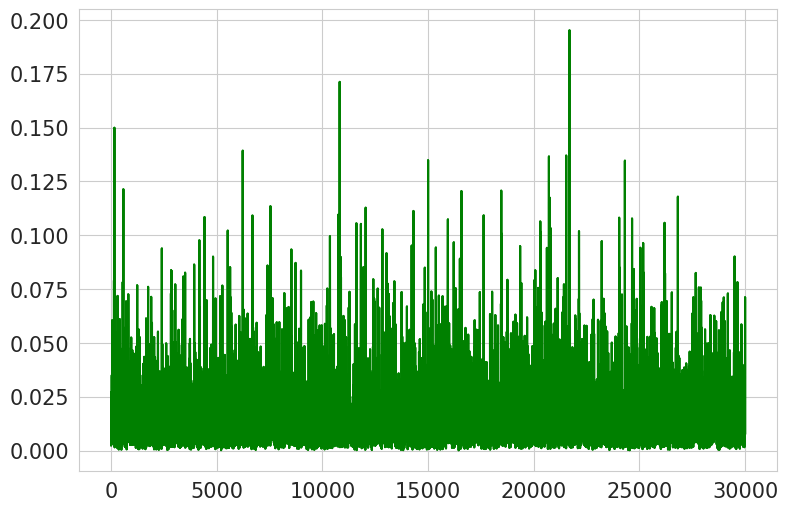

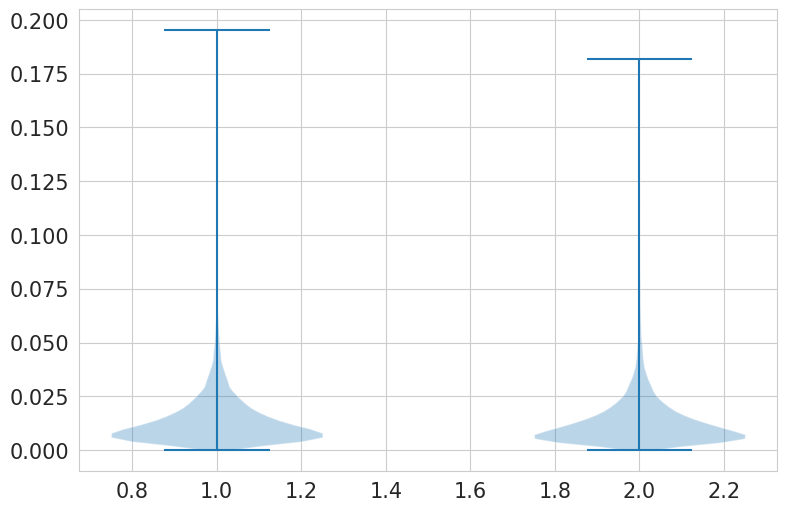

In [15]:
#Test numerical value range
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].c_star)
#Test full scale trafo numerical value range
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].full_scale_concentration)
#Test numerical value means
print(np.mean(conc_ts[name][files[0]].c_star))
print(np.mean(conc_ts[name][files[0]].net_concentration))
print(np.mean(conc_ts[name][files[1]].c_star))
print(np.mean(conc_ts[name][files[1]].net_concentration))
#Test ts shape
c = ["green"]
i=0
for name in namelist:
    for file in files:
        print(f"File: {file}")
        print("Shape:", conc_ts[name][file].net_concentration.shape)
        print(conc_ts[name][file].net_concentration)
        plt.plot(conc_ts[namelist[0]][files[0]].c_star,color=c[i])
        print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].net_concentration)))
        print("Min/Max:", np.min(conc_ts[name][file].net_concentration), "/", np.max(conc_ts[name][file].net_concentration))
        print(f"Mean: {np.mean(conc_ts[name][file].net_concentration)}")
        print(f"Std: {np.std(conc_ts[name][file].net_concentration)}")
        print(f"Percentiles: {conc_ts[name][file].calc_percentiles(percentiles=[10, 90, 95], var='net_concentration')}")    
plt.show()
#plt.violinplot([conc_ts[name][file].c_star for file in files])
plt.show()

[103.89648858333334, 23.038903871666676, 6.4709915363333295, 3.7430403243333217, 1.291780661333327]
[97.76765013333332, 27.259735805000005, 9.619464627666673, 8.762905275000008, 2.985935848166676]


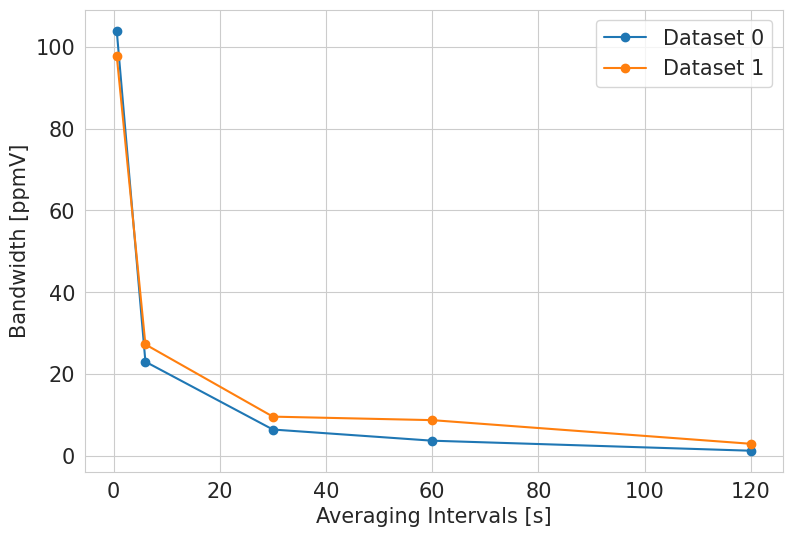

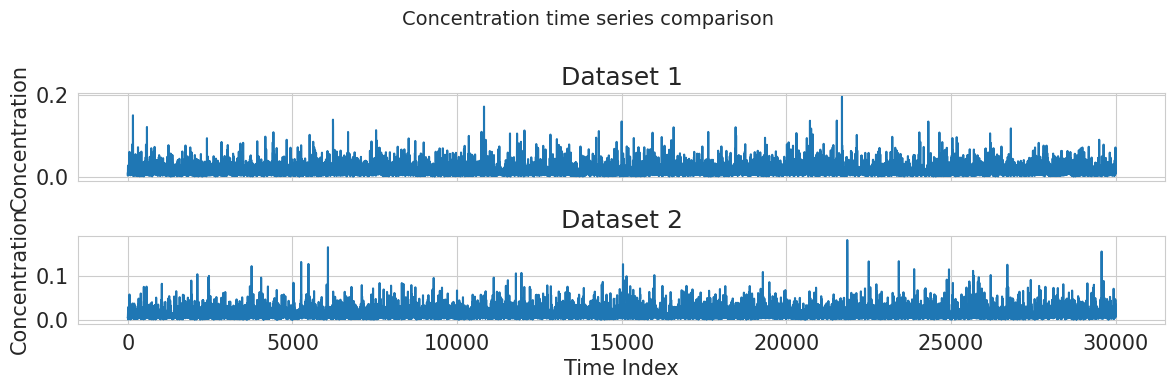

matplotlib.legend: WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1 2]
2
3
[array([ 0.      ,  0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,
        2.34375 ,  2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,
        4.6875  ,  5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,
        7.03125 ,  7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,
        9.375   ,  9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125,
       11.71875 , 12.109375, 12.5     , 12.890625, 13.28125 , 13.671875,
       14.0625  , 14.453125, 14.84375 , 15.234375, 15.625   , 16.015625,
       16.40625 , 16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375,
       18.75    , 19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125,
       21.09375 , 21.484375, 21.875   , 22.265625, 22.65625 , 23.046875,
       23.4375  , 23.828125, 24.21875 , 24.609375, 25.      , 25.390625,
       25.78125 , 26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375,
       28.125   , 28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125,
       30.46875 , 30.859375, 31.25    , 

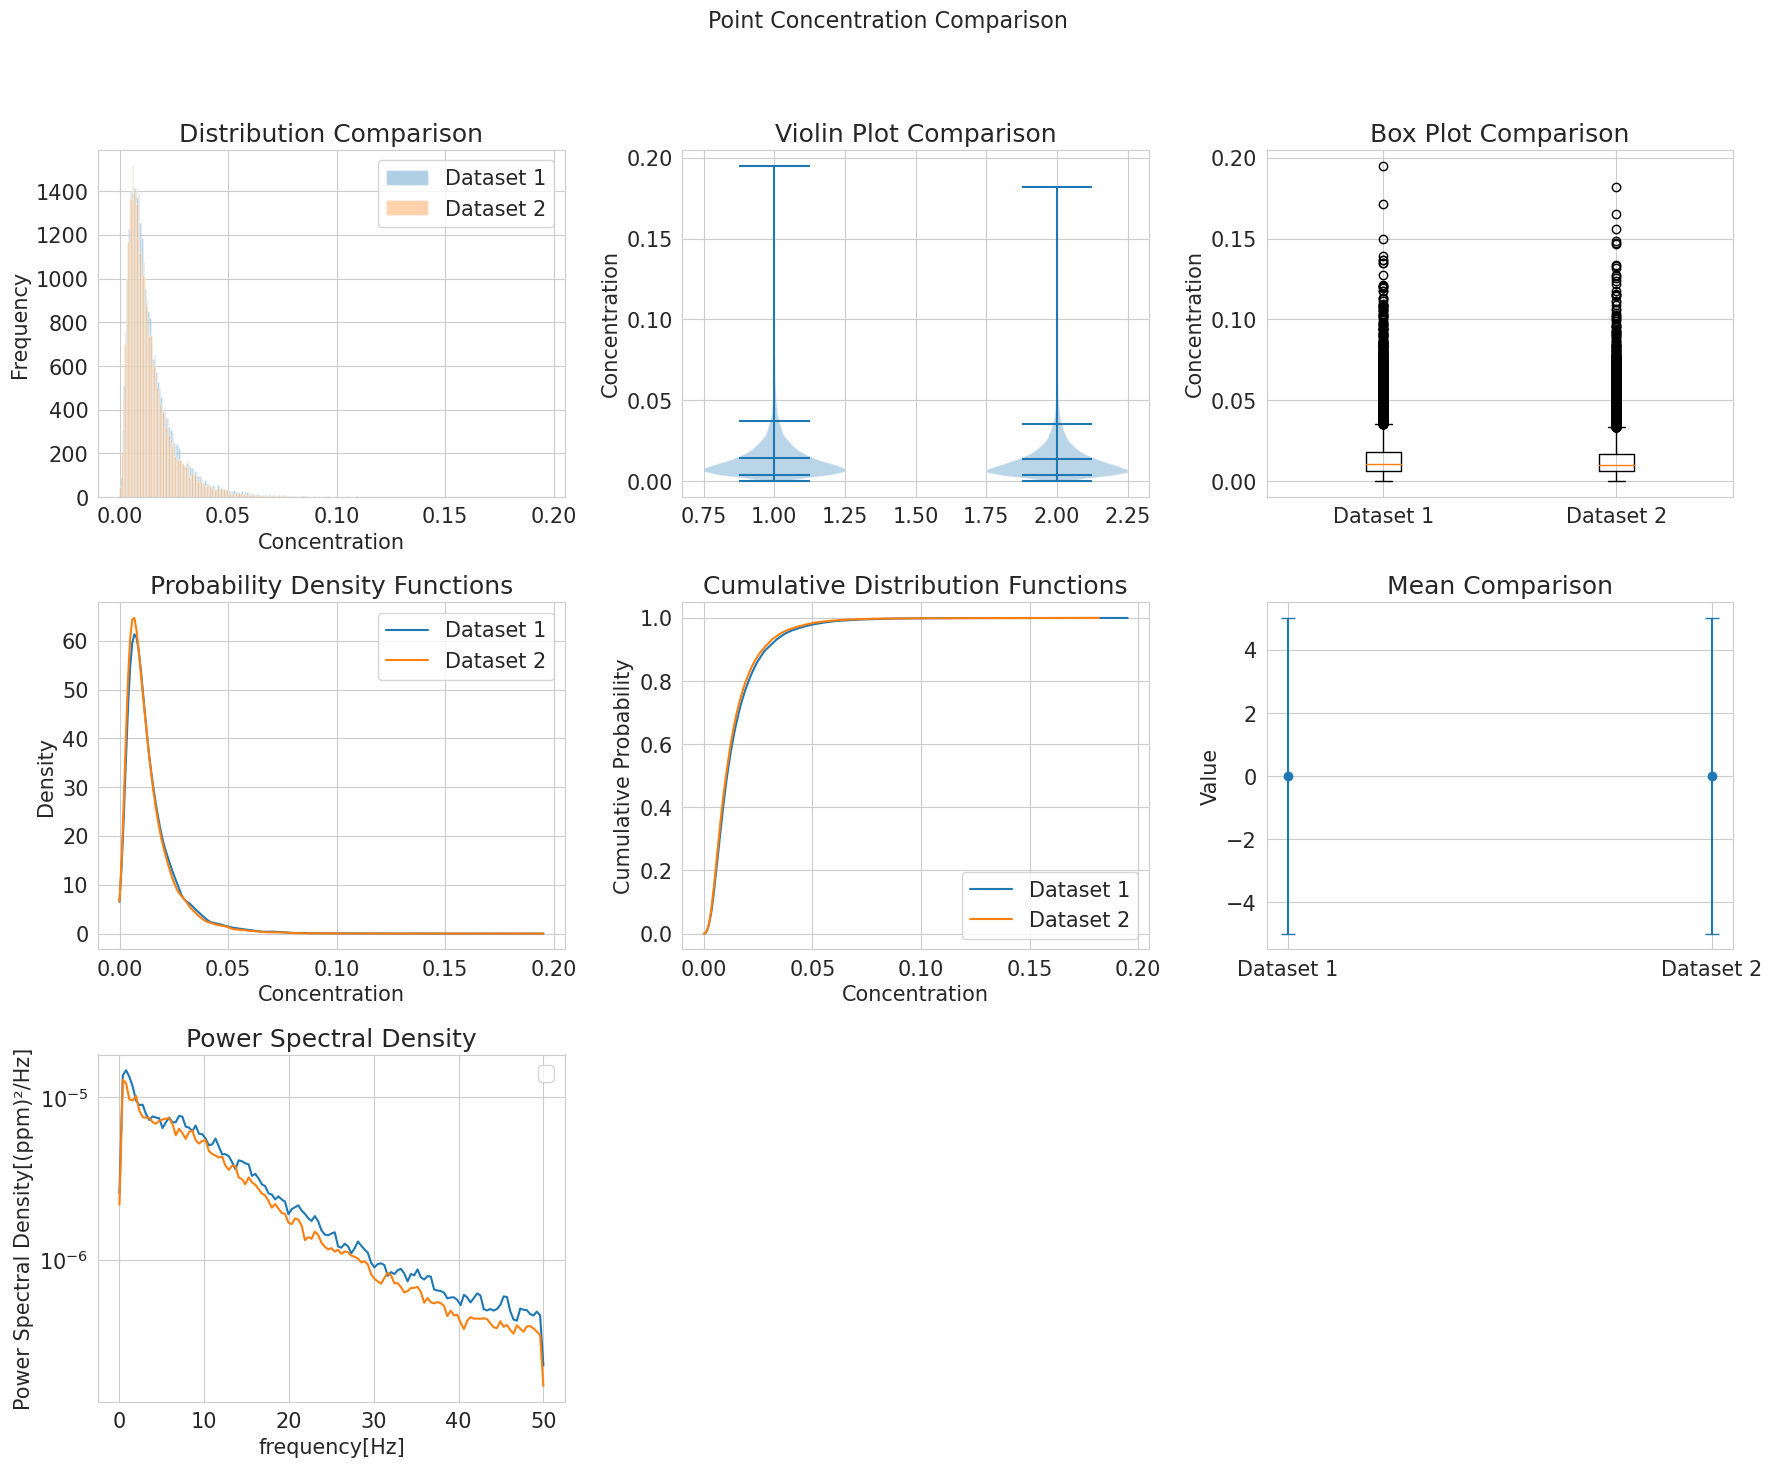


Detailed Comparison:
Mean: Dataset 1 = 0.0143, Dataset 2 = 0.0135
Std Dev: Dataset 1 = 0.0123, Dataset 2 = 0.0116
Skewness: Dataset 1 = 2.7365, Dataset 2 = 2.8395
Percentile 95: Dataset 1 = 0.0374, Dataset 2 = 0.0351
Turbulence Intensity v: Dataset 1 = 0.0083, Dataset 2 = 0.0073
Turbulence Intensity c: Dataset 1 = 0.8572, Dataset 2 = 0.8567
Pearson r (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0055
Spearman rho (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = -0.0011
RMSE (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0168


In [22]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..
#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]  
functionsForOverview = [
    "Histogram",
    "ViolinPlot",
    "BoxPlot",
    #"",
    "Pdf",
    "Cdf",
    "Means",
    "PowerDensity"
        ]
#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]][files[0]],#
    conc_ts[namelist[0]][files[1]],
    #conc_ts[namelist[0]][files[2]],
    #conc_ts[namelist[0]][files[3]],
    #conc_ts[namelist[0]][files[4]],
    #conc_ts[namelist[0]][files[5]]
]

#Bandwidth convergence plot settings
xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
Labels = None
dimensionless = False
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'
#colors = ["green",""blue"]
time_freq = 0.010 #s
averaging_intervals = [60*0.01,60*0.1,60*0.5,60*1.0,60*2.0]# [60*0.01,60*0.1,60*0.5, 60*1,60*2,60*3,60*4,60*5]#in s     #Example for [15,30 and 60 min]
#t*[[-] =[s/(m/s) * m]  = t[s] / Uref[m/s] * Lref[m]


bandwidths = []
for name in namelist:
    for file in files:
        ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals)
        bandwidths.append([np.max(avg) - np.min(avg) for avg in ts_v_avg])  # or use np.ptp(avg)(peakTopeak) for same result, but faster
for i, bandwidth in enumerate(bandwidths):
    print(bandwidth)
    plt.plot(averaging_intervals, bandwidth, "o-", 
             label=f"Dataset {i}" if Labels is None else Labels[i])
plt.xlabel("Averaging Intervals [s]")
plt.ylabel("Bandwidth [ppmV]")
plt.legend()
plt.grid(True)


compare_point_concentrations_3(DataPointsConc,functionsForOverview)


In [18]:
#from windtunnel.concentration.utils import batch_combine_data, load_combined_data_from_csv
from windtunnel.concentration.utils import *
#normal test
print(files)
file_names = ["_stats_" + file for file in files]
base_path = output_path + "Files/Point_Data_stats/UBA_thesi/"
combine_to_csv(file_names, base_path, file_type='stats', output_filename=output_path+'combined_data_nora.csv')

#file_names = [
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#2",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#3",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#4",
#    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#5"
#]
#base_path =output_path
#base_path = output_path + "Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00"
#base_path = output_path + "Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/"
#combine_to_csv(file_names, base_path, file_type='avg', output_filename=output_path+'combined_data.csv')

#base_path = output_path + "Files/Point_Data_stats/UBA_thesi/"
#combine_to_csv(file_names, base_path, file_type='stats', output_filename=output_path+'combined_data_nora.csv')

#combine_to_csv(file_names, base_path, file_type='avg', output_filename=output_path+'combined_data.csv')

['UBA_thesis_001.ts#2', 'UBA_thesis_064.ts#0']
Processing 2 stats files
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_thesi/_stats_UBA_thesis_001.ts#2
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_thesi/_stats_UBA_thesis_064.ts#0
Data saved to /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv


,Filename,X_fs [m],Y_fs [m],Z_fs [m],Wtref_fs [m/s],Avg_c_star [-],Avg_net_concentration [ppmV],Avg_full_scale_concentration [ppmV],Percentiles 95_cstar,Percentiles 95_net_concentration,percentiles95_full_scale_concentration,Peak2MeanRatio_cstar,Peak2MeanRatio_net_conc,Peak2MeanRatio_full_scale_conc
0,_stats_UBA_thesis_001.ts#2,10.0,0.0,2.0,5.0,0.0143,63.8538,1188.8970,0.0374,166.5868,3101.6897,13.6315,13.6315,13.6315
1,_stats_UBA_thesis_064.ts#0,10.0,0.0,2.0,5.0,0.0135,71.1789,1120.6902,0.0351,184.9992,2912.7563,13.4801,13.4801,13.4801


In [8]:
#full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
"""
full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
base_path = output_path + "Files/Point_Data_avg/UBA_thesi/" 
file_names = ["_avg_" + file for file in files]
for file in file_names:
    #metadata = {}
    data = []
    with open(full_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith('"'):
                # Kopfzeile mit Variablennamen
                headers = line.replace('"', '').split()
                continue
            # Wertezeile
            values = list(map(float, line.split()))
            data.append(values)
    
    df = pd.DataFrame(data, columns=headers)
    print(df.head())
"""

'\nfull_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"\nbase_path = output_path + "Files/Point_Data_avg/UBA_thesi/" \nfile_names = ["_avg_" + file for file in files]\nfor file in file_names:\n    #metadata = {}\n    data = []\n    with open(full_path, \'r\') as f:\n        for line in f:\n            line = line.strip()\n            if not line or line.startswith(\'#\'):\n                continue\n            if line.startswith(\'"\'):\n                # Kopfzeile mit Variablennamen\n                headers = line.replace(\'"\', \'\').split()\n                continue\n            # Wertezeile\n            values = list(map(float, line.split()))\n            data.append(values)\n    \n    df = pd.DataFrame(data, columns=headers)\n    print(df.head())\n'

/tmp/ipykernel_64966/3445474.py:136: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)


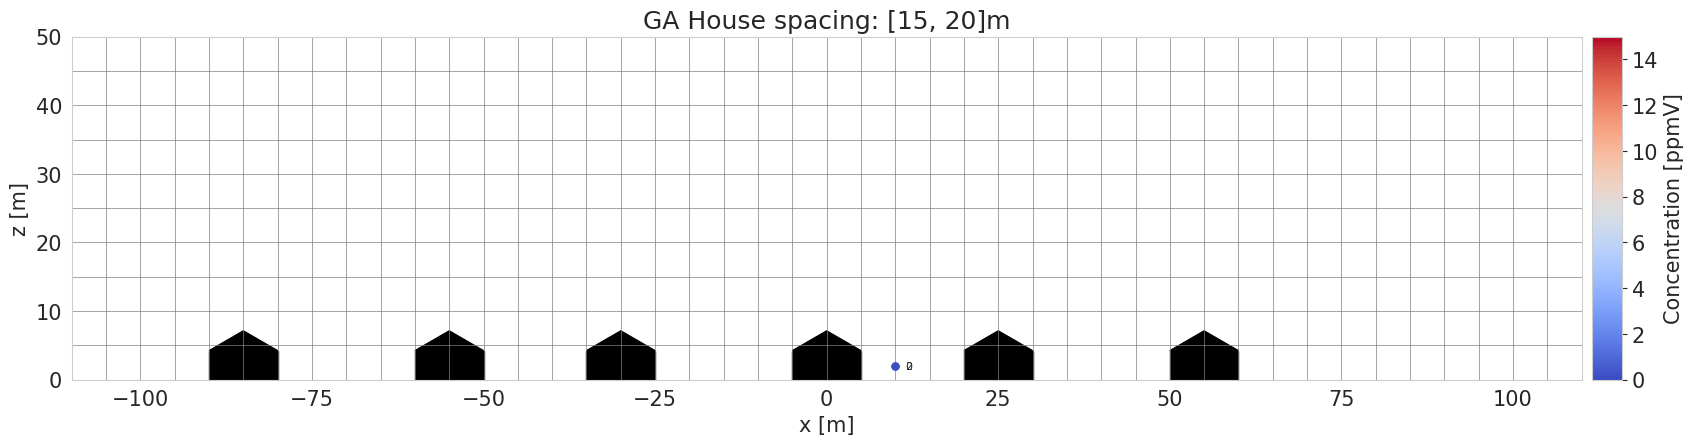

In [23]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
from windtunnel.concentration.utils import load_csv

# Parameters
READ_CSV = True
CSV_PATH = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv"

CONTINUOUS_COLORING = True  # False = threshold mode, True = continuous mode
THRESHOLDS = [1, 9]  # lower and upper thresholds
COLORMAP =  'coolwarm'  # For continuous mode: 'viridis', 'plasma', 'coolwarm', etc
COLORBARLABEL="Concentration [ppmV]"
REVERSE_COLORMAP = False #True
NORMALIZE=False
# House configuration - choose one by uncommenting
# Bebauung 1: number_houses, houses_spacing_btw, triangle_start, house_start_x
# HOUSE_CONFIG = (1, 0, np.array([[-5, 4.23], [5, 4.23], [0, 7.118]]), -5)
# HOUSE_CONFIG = (9, 10, np.array([[-85, 4.23], [-75, 4.23], [-80, 7.118]]), -85)
# HOUSE_CONFIG = (7, 20, np.array([[-95, 4.23], [-85, 4.23], [-90, 7.118]]), -95)
# HOUSE_CONFIG = (5, 40, np.array([[-105, 4.23], [-95, 4.23], [-100, 7.118]]), -105)
HOUSE_CONFIG = (6, [15, 20], np.array([[-90, 4.23], [-80, 4.23], [-85, 7.118]]), -90)  # Bebauung 5 (alternating spacing)

# Plot settings
X_MIN, X_MAX = -110, 110
Z_MIN, Z_MAX = 0, 50
GRID_SPACING = 5
FIGURE_SIZE = (20, 8)
# House dimensions
RECT_WIDTH = 10
RECT_HEIGHT = 4.23
Z0 = 0

# Load data
if READ_CSV:
    try:
        data = load_csv(CSV_PATH, columns=["X_fs [m]", "Y_fs [m]", "Z_fs [m]", "Avg_c_star [-]", "Filename"], combineCoordinates=True)
        values, points, filenames = data["Avg_c_star [-]"], data['coordinates'], data["Filename"]
        punkte = [(points[i][0], points[i][1], points[i][2], values[i]) for i in range(len(points))]
    except:
        print("CSV load failed, using hardcoded data")
        READ_CSV = False

if not READ_CSV:
    # Hardcoded example data
    punkte = [(50, 0, 2, 8.08), (7.5, 0, 2, 6.65), (10, 0, 2, 6.19), 
              (25, 0, 2, 11.27), (50, 0, 15, 3.92), (100, 0, 2, 4.38)]
    filenames = ["1", "2", "3", "4", "5", "6"]

# Unpack house configuration
number_houses, houses_spacing_btw, triangle_points, x0 = HOUSE_CONFIG

# Calculate house spacing
if isinstance(houses_spacing_btw, list):
    houses_spacing = [10 + houses_spacing_btw[0], 10 + houses_spacing_btw[1]]
else:
    houses_spacing = 10 + houses_spacing_btw


cmap = plt.cm.get_cmap(COLORMAP)
if REVERSE_COLORMAP:
    cmap = cmap.reversed()

fig, ax = plt.subplots(figsize=FIGURE_SIZE)
x_lines = int(np.ceil((X_MAX - X_MIN) / GRID_SPACING))
z_lines = int(np.ceil((Z_MAX - Z_MIN) / GRID_SPACING))
for i in range(x_lines + 1):
    x = X_MIN + i * GRID_SPACING
    ax.plot([x, x], [Z_MIN, Z_MAX], color='gray', linewidth=0.5)
for j in range(z_lines + 1):
    z = Z_MIN + j * GRID_SPACING
    ax.plot([X_MIN, X_MAX], [z, z], color='gray', linewidth=0.5)

# Draw houses
current_x = x0
current_triangle = triangle_points.copy()
for i in range(number_houses):
    rect = plt.Rectangle((current_x, Z0), RECT_WIDTH, RECT_HEIGHT,         #Add Rectangle (house base)
                        linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)
    triangle = plt.Polygon(current_triangle, closed=True, color='black')   #Add Triangle (roof)
    ax.add_patch(triangle)
    if isinstance(houses_spacing_btw, list): #Alternating spacing iteration for Bebauung 5
        spacing = houses_spacing[(i + 1) % 2]
        current_x += spacing
        current_triangle += np.array([[spacing, 0], [spacing, 0], [spacing, 0]])
    else:     # Regular spacing
        current_x += houses_spacing
        current_triangle += np.array([[houses_spacing, 0], [houses_spacing, 0], [houses_spacing, 0]])
for i, (x, y, z, c) in enumerate(punkte): # Plot data points
    if X_MIN <= x <= X_MAX and Z_MIN <= z <= Z_MAX:
        if(NORMALIZE==False): #Normalise
            normalized = np.clip(c, 0, 1)
        else:
            normalized = np.clip((c - 0) / 15, 0, 1)  # Change min/max as needed
        color = cmap(normalized)
        if CONTINUOUS_COLORING: #Continuous color mode
            normalized = np.clip((c - 0) / 15, 0, 1)  # Adjust min/max as needed
            color = cmap(normalized)
        else:  # Threshold coloring mode
            if c > THRESHOLDS[1]:
                color = 'red'
            elif c < THRESHOLDS[0]:
                color = 'blue'
            else:
                ratio = (c - THRESHOLDS[0]) / (THRESHOLDS[1] - THRESHOLDS[0])
                color = cmap(ratio)
        ax.plot(x, z, 'o', color=color, markersize=5)
        try: #labels
            label = f"{float(filenames[i][-1]):.0f}"
        except:
            label = f"{c:.1f}"
        ax.text(x + 1.5, z, label, fontsize=8, va='center')
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Z_MIN, Z_MAX)
ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_title(f'GA House spacing: {houses_spacing_btw}m')
ax.grid(False)
if not CONTINUOUS_COLORING:  #Legend for threshold-mode
    red_patch = mpatches.Patch(color='red', label=f'c > {THRESHOLDS[1]}')
    blue_patch = mpatches.Patch(color='blue', label=f'c < {THRESHOLDS[0]}')
    ax.legend(loc="upper left", handles=[red_patch, blue_patch], fontsize=10)
if not CONTINUOUS_COLORING:  #Colorbar
    norm = BoundaryNorm([float('-inf'), THRESHOLDS[0], THRESHOLDS[1], float('inf')], cmap.N)
    sm = ScalarMappable(norm=plt.Normalize(THRESHOLDS[0], THRESHOLDS[1]), cmap=cmap)
else:
    sm = ScalarMappable(norm=plt.Normalize(0, 15), cmap=cmap)  # Adjust range as needed
divider = make_axes_locatable(ax)
colorbar_axes = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)
cbar.set_label(COLORBARLABEL)
plt.show()

/tmp/ipykernel_64966/3345310120.py:95: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)


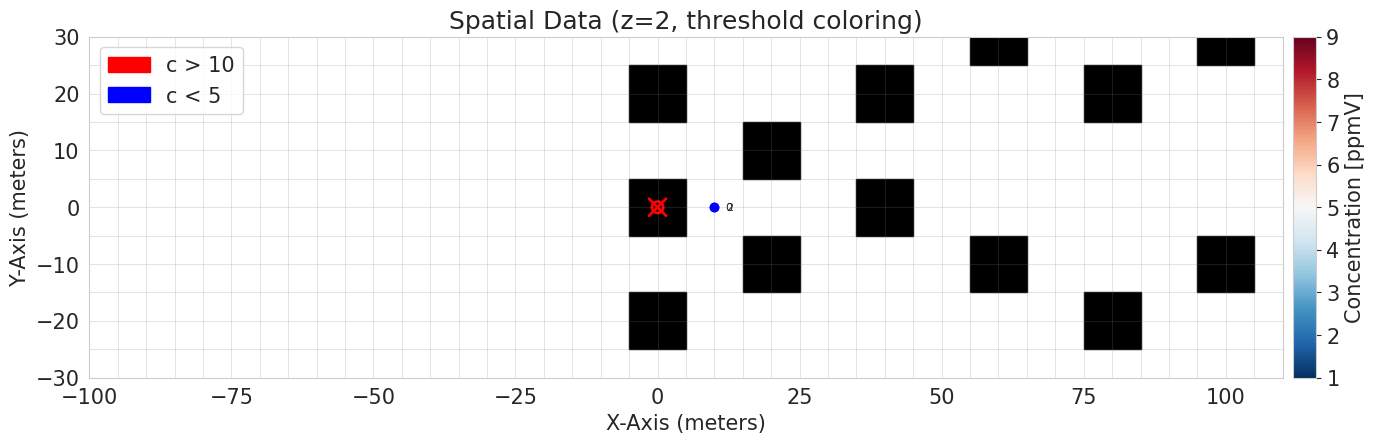

In [28]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Parameters
READ_CSV = True
CSV_PATH = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv"
CONTINUOUS_COLORING = False  # False = threshold mode, True = continuous mode
THRESHOLD_LOW = 5
THRESHOLD_HIGH = 10
Z_FILTER = 2
COLORBARLABEL="Concentration [ppmV]"
COLORMAP = 'coolwarm'  # For continuous mode: 'viridis', 'plasma', 'coolwarm', etc.

# Rectangle positions (x, y, width, height) - origin rectangle is handled separately
RECTANGLE_POSITIONS = [
    (15, 5, 10, 10), (-5, 15, 10, 10), (-5, -25, 10, 10), (15, -15, 10, 10),
    (35, 15, 10, 10), (35, -5, 10, 10), (55, -15, 10, 10), (55, 25, 10, 10),
    (75, 15, 10, 10), (75, -25, 10, 10), (95, -15, 10, 10), (95, 25, 10, 10)
]
# Plot settings
X_MIN, X_MAX = -100, 110
Y_MIN, Y_MAX = -30, 30
GRID_SPACING = 5

# Load data
if READ_CSV:
    try:
        data = load_csv(CSV_PATH, columns=["X_fs [m]", "Y_fs [m]", "Z_fs [m]", "Avg_c_star [-]", "Filename"], combineCoordinates=True)
        values, points, filenames = data["Avg_c_star [-]"], data['coordinates'], data["Filename"]
        punkte = [(points[i][0], points[i][1], points[i][2], values[i], filenames[i]) for i in range(len(points))]
    except:
        print("CSV load failed, using hardcoded data")
        READ_CSV = False
if not READ_CSV:
    # Hardcoded example data
    punkte = [(50, 0, 2, 8.08, "1"), (7.5, 0, 2, 6.65, "2"), (10, 0, 2, 6.19, "3"), 
              (25, 0, 2, 11.27, "4"), (50, 15, 2, 3.92, "5"), (100, 0, 2, 4.38, "6")]


fig, ax = plt.subplots(figsize=(14, 8))
for x in np.arange(X_MIN, X_MAX + GRID_SPACING, GRID_SPACING):
    ax.plot([x, x], [Y_MIN, Y_MAX], color='gray', linewidth=0.5, alpha=0.3)
for y in np.arange(Y_MIN, Y_MAX + GRID_SPACING, GRID_SPACING):
    ax.plot([X_MIN, X_MAX], [y, y], color='gray', linewidth=0.5, alpha=0.3)

ax.add_patch(plt.Rectangle((-5, -5), 10, 10, color='black'))               # Add origin rectangle (centered at 0,0)
for x, y, width, height in RECTANGLE_POSITIONS:                            # Add other rectangles
    ax.add_patch(plt.Rectangle((x, y), width, height, color='black'))
ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=2))  # Origin marker (red cross)
ax.plot([-1.5, 1.5], [-1.5, 1.5], 'r-', linewidth=2)
ax.plot([-1.5, 1.5], [1.5, -1.5], 'r-', linewidth=2)
filtered_points = [p for p in punkte if len(p) >= 4 and p[2] == Z_FILTER and p[3] is not None  # Filter and plot points
                   and X_MIN <= p[0] <= X_MAX and Y_MIN <= p[1] <= Y_MAX]

for x, y, z, c_val, filename in filtered_points:
    # Get color based on mode
    if CONTINUOUS_COLORING:
        normalized = np.clip((c_val - 0) / 15, 0, 1)  # Adjust min/max as needed
        color = plt.cm.get_cmap(COLORMAP)(normalized)
    else:
        # Threshold coloring
        if c_val > THRESHOLD_HIGH:
            color = 'red'
        elif c_val < THRESHOLD_LOW:
            color = 'blue'
        else:
            ratio = (c_val - THRESHOLD_LOW) / (THRESHOLD_HIGH - THRESHOLD_LOW)
            color = plt.cm.RdBu(1 - ratio)
    ax.plot(x, y, 'o', color=color, markersize=6)
    try:    # Add label
        label = f"{float(filename[-1]):.0f}"
    except:
        label = f"{c_val:.1f}"
    ax.text(x + 2, y, label, fontsize=8, va='center')
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_aspect('equal')
ax.set_xlabel('X-Axis (meters)')
ax.set_ylabel('Y-Axis (meters)')
ax.set_title(f'Spatial Data (z={Z_FILTER}, {"continuous" if CONTINUOUS_COLORING else "threshold"} coloring)')
ax.grid(False)
if not CONTINUOUS_COLORING: #If threshold plotting add corresponding notation legend
    red_patch = mpatches.Patch(color='red', label=f'c > {THRESHOLD_HIGH}')
    blue_patch = mpatches.Patch(color='blue', label=f'c < {THRESHOLD_LOW}')
    ax.legend(handles=[red_patch, blue_patch])
if not CONTINUOUS_COLORING:  #Colorbar
    norm = BoundaryNorm([float('-inf'), THRESHOLDS[0], THRESHOLDS[1], float('inf')], cmap.N)
    sm = ScalarMappable(norm=plt.Normalize(THRESHOLDS[0], THRESHOLDS[1]), cmap=cmap)
else:
    sm = ScalarMappable(norm=plt.Normalize(0, 15), cmap=cmap)  # Adjust range as needed
divider = make_axes_locatable(ax)
colorbar_axes = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)
cbar.set_label(COLORBARLABEL)
plt.tight_layout()
plt.show()

5
4
5
4
5
2
0


IndexError: list index out of range

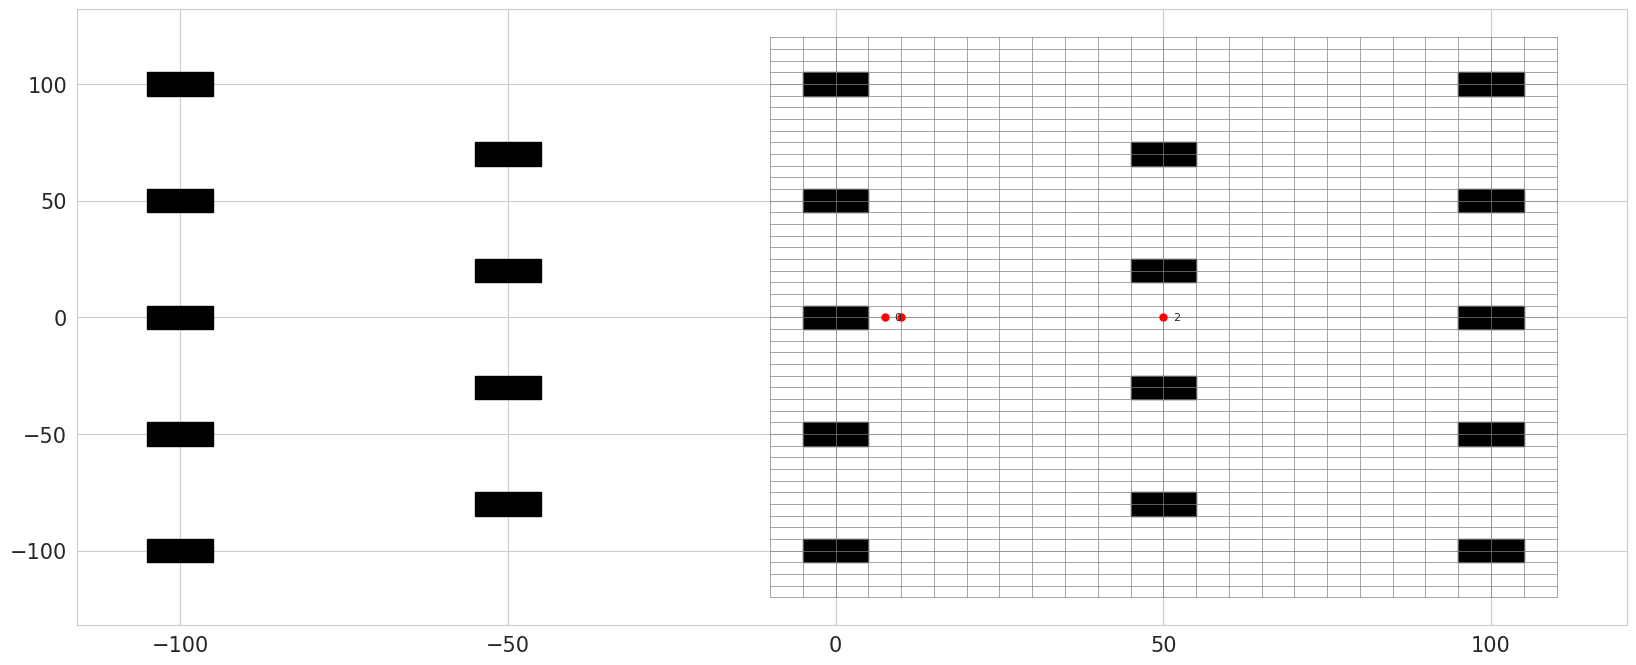

In [29]:
#Hier wäre es wahrscheinlich sinnvoller gewesen mit einer Funktion zu arbeiten und nur die Koordinaten generieren zu lassen
#Zum beispiel mit einer weiteren Funktion oder einem llm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
from windtunnel.concentration.utils import load_data_from_csv


# Bereiche und Meter pro Kästchen festlegen
x_min, x_max = -10, 110
y_min, y_max = -120, 120
spacing = 5  # Abstand zwischen Linien/Kästchen
z_level = 2  # Höhe für die horizontale Ebene

# Settings für alle Häuser
rect_width = 10  # von -5 bis 5
rect_height = 10  # für horizontale Ansicht

figSize = (20, 8)

# Bebauung auswählen
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 1,[1,1], 0, np.array([[-5, 4.23], [5, 4.23], [0, 7.118]]), -5, -5  # Bebauung 1
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 9,[7,6], 10, np.array([[-85, -65], [-75, -55], [-80, -60]]), -85, -65  # Bebauung 2
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 7,[6,7], 20, np.array([[-95, -100], [-85, -90], [-90, -95]]), -95, -100  # Bebauung 3
number_houses, number_houses_y_i,houses_spacing_btw, triangle_points, x0, y0 = 5,[5,4], 40, np.array([[-105, -105], [-95, -95], [-100, -100]]), -105, -105  # Bebauung 4
#number_houses,number_houses_y_i, houses_spacing_btw, triangle_points, x0, y0 = 6,[6,6],[15, 20], np.array([[-90, 4.23], [-80, 4.23], [-85, 7.118]]), -90, -5  # Bebauung 5
#FIX Bebauung5

# Daten einlesen
readFromCsv = False  # If False overgive through punkte = [(x,y,z,c),..] manually
#path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/Building_plots/Python code/messpunkte_1.csv"
path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv"


# Anzahl Spacing zwischen häusern und Häuseranzahl
if isinstance(houses_spacing_btw, list):
    #y_start_i = [y0,y0+houses_spacing_btw[1]/2]
    houses_spacing = [0, 0]
    houses_spacing[0] = 10 + houses_spacing_btw[0]  # Abstand zwischen Häuserkanten (longitudinal)
    houses_spacing[1] = 10 + houses_spacing_btw[1]  # Abstand zwischen Häuserkanten (longitudinal)
    # Für Bebauung 5: y-Spacing bleibt konstant bei 5m zwischen Häuserkanten
    houses_y_spacing = 10 + 5  # konstant 5m zwischen Häuserkanten
else:
    houses_spacing = 10 + houses_spacing_btw  # Abstand zwischen Häuserkanten (Mittelpunkte Häuser + Abstand)
    y_start_i = [y0,y0+houses_spacing_btw/2]


# Messpunkte einlesen
if readFromCsv:
    data = load_csv(path,columns=["X_fs [m]", "Y_fs [m]", "Z_fs [m]","Avg_c_star [-]","Filename"], combineCoordinates=True)
    print(data)
    values,points = data["Avg_c_star [-]"], data['coordinates']
    Filenames = data["Filename"]
    print(Filenames)
    punkte = [(points[i][0], points[i][1], points[i][2], values[i]) for i in range(0, len(points))]
else:
    # Fallback data if CSV reading fails for example visualisation
    punkte = [(50, 0, 2, 8.0811129906061),(0, 0, 0, None),(7.5, 0, 2, 6.65164122168862),(10, 0, 2, 6.19026498307227),
              (12.5, 0, 2, 5.52762603635695),(15, 0, 2, 5.70030368873425),(17.5, 0, 2, 6.77501508465002),
              (20, 0, 2, 8.12403269141749),(25, 0, 2, 11.2717136599455),(30, 0, 2, 12.8241234543974),
              (50, 0, 2, 7.94929705114026),(100, 0, 2, 4.37599132679174),(50, 15, 2, 3.92475487135893)]


# Linienanzahl berechnen
x_lines = int(np.ceil((x_max - x_min) / spacing))
y_lines = int(np.ceil((y_max - y_min) / spacing))
# Erstellen der Figur und Achse
fig, ax = plt.subplots(figsize=figSize)
# Gitterlinien für X-Y Ebene (Draufsicht)
for i in range(x_lines + 1):
    x = x_min + i * spacing
    ax.plot([x, x], [y_min, y_max], color='gray', linewidth=0.5)
for j in range(y_lines + 1):
    y = y_min + j * spacing
    ax.plot([x_min, x_max], [y, y], color='gray', linewidth=0.5)


# Häuser plotten
for i in range(number_houses):   #x
    y0 = y_start_i[i%2]
    number_houses_y = number_houses_y_i[i%2]
    print(number_houses_y)
    for j in range(number_houses_y): #y 
        # Rechteck (Draufsicht)
        rect = plt.Rectangle((x0, y0), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='black')
        ax.add_patch(rect)
        # Update to next position
        # Bebauung 5 (spezielle Behandlung)
        if isinstance(houses_spacing, list):
            # Alternating spacing pattern für x-direction
            x0 = x0 + houses_spacing[(i + 1) % 2]
            # y-position alterniert zwischen zwei Reihen
            if i % 2 == 0:
                y0 = y0  # erste Reihe
            else:
                y0 = y0 + houses_y_spacing if i == 1 else y0 - houses_y_spacing  # zweite Reihe
        # Alle anderen Bebauungen (1-4)
        else:
            y0 = y0 + houses_spacing
            #print(x0)
            #print(y0)
    x0 = x0 + houses_spacing

# Nur Punkte mit z=z_level für Horizontal
punkte_z_level = [p for p in punkte if p[2] == z_level and p[3] is not None]

# Farbzuordnungsfunktion
def get_color(c):
    if c > 0.0015:
        return 'red'
    elif c < 0.0015:
        return 'blue'
    else:
        ratio = (c - 1) / 8
        return plt.cm.RdBu(1 - ratio)  # Korrekte Nutzung der colormap

# Punkte plotten
for i,(x, y, z, c) in enumerate(punkte_z_level):
    if x_min <= x <= x_max and y_min <= y <= y_max:
        color = get_color(c)
        ax.plot(x, y, 'o', color=color, markersize=5)
        #ax.text(x + 1.5, y, f'{c:.1f}', fontsize=8, verticalalignment='center')
        print(Filenames[i][-1])
        ax.text(x + 1.5, y, f'{float(Filenames[i][-1]):.0f}', fontsize=8, verticalalignment='center')
# Settings for colorbar and figure
# --- Color coding and thresholds ---
thresholds = [0, 0.0019]  # lower and upper thresholds (exclusive)
cmap = plt.cm.RdBu   # colormap for intermediate values
cmap = cmap.reversed()

# Achsenanpassung
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
# Koordinatenachsen
#ax.axhline(0, color='blue', linewidth=1)
#ax.axvline(0, color='blue', linewidth=1)
# Rotes Kreuz im Koordinatenursprung
circle = plt.Circle((0, 0), radius=1.0, color='red', fill=False, linewidth=2)
ax.add_patch(circle)
line1 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 - 1.5, 0 + 1.5], color='red', linewidth=2)
line2 = plt.Line2D([0 - 1.5, 0 + 1.5], [0 + 1.5, 0 - 1.5], color='red', linewidth=2)
ax.add_line(line1)
ax.add_line(line2)
ax.set_xlabel('X-Achse (Meter)')
ax.set_ylabel('Y-Achse (Meter)')
ax.set_title(f'Horizontal View (z={z_level}m) - House spacing: {houses_spacing_btw}m')
ax.grid(False)
# --- Legend ---
red_patch = mpatches.Patch(color='red', label=f'c > {thresholds[1]}')
blue_patch = mpatches.Patch(color='blue', label=f'c < {thresholds[0]}')
plt.legend(loc="upper left", handles=[red_patch, blue_patch], fontsize=10)
# --- Colorbar ---
norm = BoundaryNorm([float('-inf'), thresholds[0], thresholds[1], float('inf')], cmap.N)
sm = ScalarMappable(norm=plt.Normalize(thresholds[0], thresholds[1]), cmap=cmap)
divider = make_axes_locatable(ax)
colorbar_axes = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', cax=colorbar_axes)
cbar.set_label('c*[-]')
plt.show()

In [12]:
pip install numpy_stl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
#Start visualisation of map with concentration location and averages, with model in background
from windtunnel.concentration.utils import stl_to_2d_plot, add_crosses, show_multiple_projections
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d
from windtunnel.concentration.utils import add_velocity_field
import matplotlib.pyplot as plt
import numpy as np

defaultdict(<class 'list'>, {'Avg_c_star [-]': [0.0143, 0.0135], 'Filename': ['_stats_UBA_thesis_001.ts#2', '_stats_UBA_thesis_064.ts#0'], 'coordinates': [(10.0, 0.0, 2.0), (10.0, 0.0, 2.0)]})
[(50, 0, 2, 8.0811129906061), (0, 0, 0, None), (7.5, 0, 2, 6.65164122168862), (10, 0, 2, 6.19026498307227), (12.5, 0, 2, 5.52762603635695), (15, 0, 2, 5.70030368873425), (17.5, 0, 2, 6.77501508465002), (20, 0, 2, 8.12403269141749), (25, 0, 2, 11.2717136599455), (30, 0, 2, 12.8241234543974), (50, 0, 2, 7.94929705114026), (100, 0, 2, 4.37599132679174), (50, 15, 2, 3.92475487135893)]
[0.0143, 0.0135]
[(10.0, 0.0, 2.0), (10.0, 0.0, 2.0)]
Loading STL file: /home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl
No valid points or values provided
[0.0143, 0.0135]
[(10.0, 0.0), (10.0, 0.0)]


IndexError: list index out of range

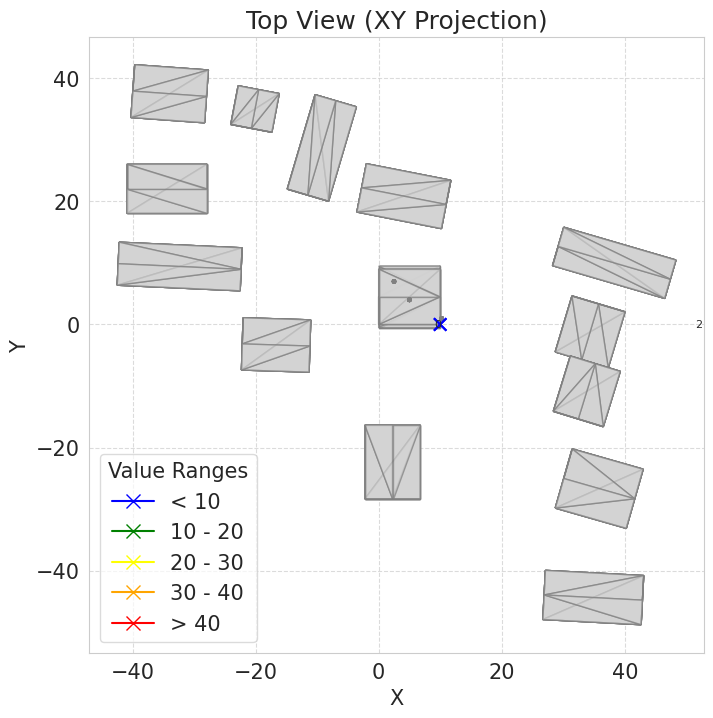

In [32]:
from windtunnel.concentration.utils import load_avg_file

#stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240206_BfS_model_scale_complete.stl"
stl_file =  "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl" ## Path to STL/Model background file

ref_position = (0,0)
addVelocitys=True
interpolate_velocityField = True #Interpolate between wind field measurement locations
toFullScale="True"
twoD = True

readFromCsv=True
#path = output_path
path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv"
#Read-in XY coordinates and values of concentration measurements
if readFromCsv:
    data = load_csv(path,columns=["X_fs [m]", "Y_fs [m]", "Z_fs [m]","Wtref_fs","Avg_c_star [-]","Filename"], combineCoordinates=True)
    print(data)
    values,points = data["Avg_c_star [-]"], data['coordinates']
    Filenames = data["Filename"]
    if(addVelocitys==True):
        wind_speeds = data["Wtref_fs"]
        points_wtref = points
    #punkte = [(points[i][0], points[i][1], points[i][2], values[i]) for i in range(0, len(points))]
    print(punkte)
    print(values)
    print(points)

else:
    #model scale
    points = [(-1020,0),(-970,-105),(930,270),(-850,0),(15, 25),(20, 10),(25, 15),(30, 30),(x,y)]
    #Average concentration values
    values = [9.2484,3.557,72.931, 15, 25, 35, 45]#,c] #[77.262008,
    #####Add velocity field, Velocity time series values for background overlaying wind field
    points_wtref = [(-1800,-1800),(1800,-1800),(-1800,1800),(1800,1800)]
    points_wtref = [(5.0,5.0),(5.0,5.0),(5.0,5.0),(5.0,5.0)]
    wind_speeds = [0,1,2,3]
    

#path_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/UBA/loc+value.csv"
"""
for file_name in file_names:
    points, values = load_data_from_csv(path) #File is in full scale 
    data_dict = load_avg_file(file_path + file_name)
    x = data_dict['metadata']['x (measurement relativ to source)']['value']
    y = data_dict['metadata']['y (measurement relativ to source)']['value']
    #z.append(data_dict['metadata']['z (measurement relativ to source)']['value'])
    c = data_dict['data'][0]['net_concentration [ppmV]']
    #To test out wind speeds
    wind_speeds.append(data_dict['metadata']['wtref']['value'])
    points_ms.append((x,y))
    values_ms.append(c)
"""

#Coloring
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40]
colors = ['blue','green', 'yellow', 'orange', 'red']

#Call stl to polygon print
if(twoD==True):
    fig, ax = stl_to_2d_plot(stl_file, projection='xy',toFullScale=toFullScale,scaling=1)
#fig, ax = plot_stl_3d(stl_file, azim=0,elev=30,x_range=[-1000,1000],y_range=[-200,200], z_range=[-200,200])
# Add velocity field (speeds only)  #toFullScale=False
if(addVelocitys==True):
    add_velocity_field(ax, points_wtref, values=wind_speeds, interpolate=interpolate_velocityField, grid_density=40, transparencyFactor=0.2,is_latlon=False, zorder=5,show_contour_lines=False)
# Add crosses to the plot#
if(twoD==True):
    points = [points_i[0:2] for points_i in points]
    print(values)
    print(points)
    add_crosses(ax, points, values=values, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
#add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
#Add point : time series numbers
for i,(x, y, z, c) in enumerate(punkte_z_level):
    ax.text(x + 1.5, y, f'{float(Filenames[i][-1]):.0f}', fontsize=8, verticalalignment='center')
ax.set_xlabel("X_ms[mm]")
ax.set_ylabel("Y_ms[mm]")
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()

defaultdict(<class 'list'>, {'Avg_c_star [-]': [0.0143, 0.0135], 'Filename': ['_stats_UBA_thesis_001.ts#2', '_stats_UBA_thesis_064.ts#0'], 'coordinates': [(10.0, 0.0, 2.0), (10.0, 0.0, 2.0)]})
[(50, 0, 2, 8.0811129906061), (0, 0, 0, None), (7.5, 0, 2, 6.65164122168862), (10, 0, 2, 6.19026498307227), (12.5, 0, 2, 5.52762603635695), (15, 0, 2, 5.70030368873425), (17.5, 0, 2, 6.77501508465002), (20, 0, 2, 8.12403269141749), (25, 0, 2, 11.2717136599455), (30, 0, 2, 12.8241234543974), (50, 0, 2, 7.94929705114026), (100, 0, 2, 4.37599132679174), (50, 15, 2, 3.92475487135893)]
[0.0143, 0.0135]
[(10.0, 0.0, 2.0), (10.0, 0.0, 2.0)]


IndexError: list index out of range

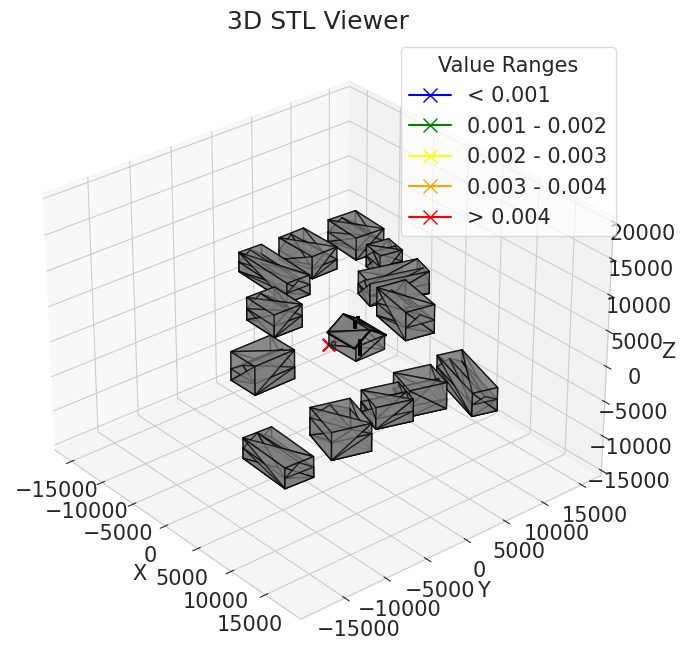

In [33]:
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d, load_data_from_csv
import matplotlib.pyplot as plt
import numpy as np

# Path to your STL file for city structure
stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl"
#Path to csv file containing locations and concentration values measured in format /x,y,z,c
#path = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/UBA/loc+value.csv"
#Visualisationrange
x_range=None#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
y_range=None#[-45000,45000]#[5000,15000]#[-45000,45000]
#x_range=[-30000,-10000]#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
#y_range=[30000,50000]#[-45000,45000]#[5000,15000]#[-45000,45000]
z_range=[-15000,20000]
ToFullScale=False
scale = 400 ##For full scale trafo


readFromCsv=True
#path = output_path
path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/combined_data_nora.csv"
#Read-in XY coordinates and values of concentration measurements
if readFromCsv:
    data = load_csv(path,columns=["X_fs [m]", "Y_fs [m]", "Z_fs [m]","Wtref_fs","Avg_c_star [-]","Filename"], combineCoordinates=True)
    print(data)
    values,points,Filenames = data["Avg_c_star [-]"], data['coordinates'], data["Filename"]
    if(addVelocitys==True):
        wind_speeds = data["Wtref_fs"]
        points_wtref = points
    #punkte = [(points[i][0], points[i][1], points[i][2], values[i]) for i in range(0, len(points))]
    print(punkte)
    print(values)
    print(points)
else:
    #model scale
    points = [(-1020,0),(-970,-105),(930,270),(-850,0),(15, 25),(20, 10),(25, 15),(30, 30),(x,y)]
    #Average concentration values
    values = [9.2484,3.557,72.931, 15, 25, 35, 45]#,c] #[77.262008,
    #####Add velocity field, Velocity time series values for background overlaying wind field
    points_wtref = [(-1800,-1800),(1800,-1800),(-1800,1800),(1800,1800)]
    points_wtref = [(5.0,5.0),(5.0,5.0),(5.0,5.0),(5.0,5.0)]
    wind_speeds = [0,1,2,3]


#To Full scale range
if(ToFullScale):
    x_range = [i * scale / 1000  for i in x_range] 
    y_range = [i * scale / 1000  for i in y_range] 
    z_range = [i * scale / 1000  for i in z_range]
fig, ax = plot_stl_3d(stl_file,elev=30,azim=320,x_range=x_range,y_range=y_range,z_range=z_range,toFullScale="True",scaling=scale)
#fig, ax = plot_stl_3d(stl_file,elev=0,azim=0)
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40] 
thresholds = [i / 10000 for i in thresholds]
colors = ['blue', 'green', 'yellow', 'orange', 'red']
add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,                   #Add marks/crosses
              size=80, linewidth=1.5)
for i,(x, y, z, c) in enumerate(punkte_z_level):                                                  #Add time series numbers
    ax.text(x + 1.5, y,z, f'{float(Filenames[i][-1]):.0f}', fontsize=8, verticalalignment='center',zorder=12)  
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()

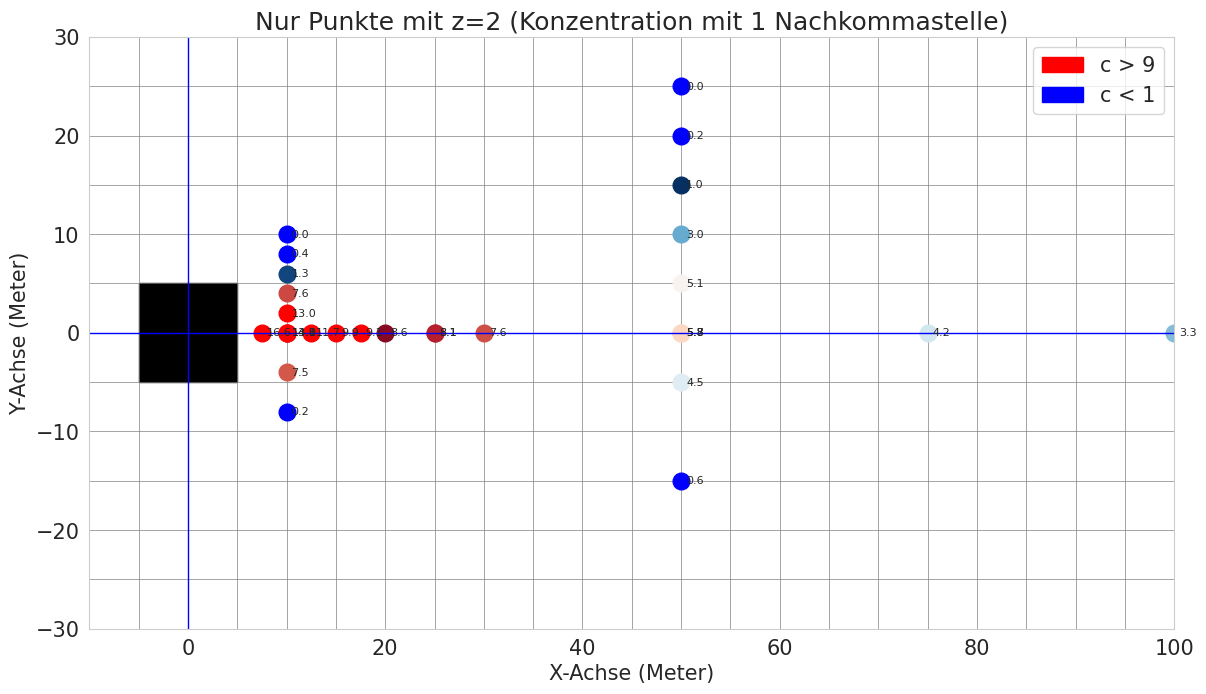

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Bereiche definieren
x_min, x_max = -10, 100
y_min, y_max = -30, 30
spacing = 5  # Abstand zwischen Linien in Metern

# Linienanzahl berechnen
x_lines = int(np.ceil((x_max - x_min) / spacing))
y_lines = int(np.ceil((y_max - y_min) / spacing))

fig, ax = plt.subplots(figsize=(14, 8))

# Gitterlinien zeichnen
for i in range(x_lines + 1):
    x = x_min + i * spacing
    ax.plot([x, x], [y_min, y_max], color='gray', linewidth=0.5)

for j in range(y_lines + 1):
    y = y_min + j * spacing
    ax.plot([x_min, x_max], [y, y], color='gray', linewidth=0.5)

# Schwarze 2x2 Felder in der Mitte
for dx in [0.5, -0.5]:
    for dy in [0.5, -0.5]:
        x0 = -spacing/2 + dx * spacing
        y0 = -spacing/2 + dy * spacing
        rect = plt.Rectangle((x0, y0), spacing, spacing, color='black')
        ax.add_patch(rect)

# Neue Messpunkte mit Koordinaten und Konzentrationen
punkte = [
    (50, 0, 2, 5.84287089033691),
    (50, 5, 2, 5.09859595682674),
    (50, 10, 2, 2.98886433768624),
    (50, 15, 2, 1.02305896833557),
    (50, 20, 2, 0.202236630954002),
    (50, 25, 2, 0.00205992647641945),
    (50, -5, 2, 4.50611336835675),
    (50, -15, 2, 0.608540377348909),
    (7.5, 0, 2, 16.5982032658532),
    (10, 0, 2, 14.0803862218811),
    (12.5, 0, 2, 11.6858884092025),
    (15, 0, 2, 9.93012024915678),
    (17.5, 0, 2, 9.13859470076357),
    (20, 0, 2, 8.63621265021175),
    (25, 0, 2, 8.11519104657238),
    (30, 0, 2, 7.58693528305659),
    (50, 0, 2, 5.74686846301576),
    (75, 0, 2, 4.23171605765212),
    (100, 0, 2, 3.27102608371505),
    (10, 0, 1, 9.91289299934861),
    (10, 0, 2, 13.7506240797771),
    (10, 0, 4, 25.0750319733066),
    (10, 0, 6, 51.9828976157176),
    (10, 0, 8, 120.138981271492),
    (10, 0, 10, 75.4571856794695),
    (10, 0, 12, 2.27672253137928),
    (50, 0, 2, 5.84994819255544),
    (50, 0, 6, 6.73458254897626),
    (50, 0, 10, 5.61267341213733),
    (50, 0, 14, 2.42026504687858),
    (50, 0, 18, 0.447139986919479),
    (50, 0, 22, 0.0305013827133299),
    (10, 0, 2, 13.9932606170865),
    (10, 2, 2, 13.0364814941968),
    (10, 4, 2, 7.64499627309249),
    (10, 6, 2, 1.33128651936484),
    (10, 8, 2, 0.392317309017577),
    (10, 10, 2, 0.0383563994082062),
    (10, -4, 2, 7.47280230937592),
    (10, -8, 2, 0.174029601097697),
    (25, 0, 1, 6.25840340770818),
    (25, 0, 2, 8.116680639725),
    (25, 0, 4, 11.9216028372785),
    (25, 0, 8, 19.6208040650182),
    (25, 0, 12, 6.90769001425535),
    (25, 0, 16, 0.119008018894885),
]

# Filter nur Punkte mit z=2
gefilterte_punkte_z2 = [p for p in punkte if p[2] == 2]

# Farbenfunktion
def get_color(c):
    if c > 9:
        return 'red'
    elif c < 1:
        return 'blue'
    else:
        ratio = (c - 1) / (9 - 1)
        return plt.cm.RdBu(1 - ratio)

# Plotten mit Beschriftung der Konzentration
for (x, y, z, c) in gefilterte_punkte_z2:
    if x_min <= x <= x_max and y >= y_min and y <= y_max:
        color = get_color(c)
        ax.plot(x, y, 'o', color=color, markersize=12)
        # Konzentration mit einer Nachkommastelle anzeigen
        ax.text(x + 0.5, y, f'{c:.1f}', fontsize=8, verticalalignment='center')

# Achsen & Legende
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axhline(0, color='blue', linewidth=1)
ax.axvline(0, color='blue', linewidth=1)
ax.set_xlabel('X-Achse (Meter)')
ax.set_ylabel('Y-Achse (Meter)')
ax.set_title('Nur Punkte mit z=2 (Konzentration mit 1 Nachkommastelle)')
ax.grid(False)

# Legende für Farben
red_patch = mpatches.Patch(color='red', label='c > 9')
blue_patch = mpatches.Patch(color='blue', label='c < 1')
plt.legend(handles=[red_patch, blue_patch])

plt.show()
